# In this work, only LoF mutations are used: calculate how many risk genes we can obtain with Nsample = 550

# Mis3 is also added below


## Some ways have been used:

### Don't know any count information $=>$ use Poisson distribution

### Know counts from published data (Removed)

### Use TADA method (Removed)

### Use the trio package (Removed)


I randomly chose 1000 genes, but it's probably better if choosing top 1000 genes from TADA results.

# Simulate counts from the Poisson distribution

## Some main steps:

nGene = Number of genes ( ~ 18500 genes)

. Randomly choose risk genes with prob = 1000/nGene

. Add relative risk into mutation rates of risk genes 

. Use Poisson distribution to sample all genes with new mutation rates

. Use Poisson test to obtain p values:

    At the $i^{th}$ gene, $p_value = P(X >= x_i| lambda = 2*Nsample*mu_i)$
 
 . Count genes with pvalues < 0.05
 
 Didn't adjust for all tests, with Nsample = 550: it's difficult to obtain significant values after adjustment


# Real counts from published data

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations



### We will use the Autism data from the TADA paper to have obtain some neccessary information

In [128]:
data <- read.csv("TADA/data/TADA_results.csv", header = TRUE, as.is = TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)

Nsample_old <- 2231 ##There are 308 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- sum(data$dn.LoF)
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
nDenovo

mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

##Choose nRiskGene = 1000 genes, using index
indexRiskGene <- sample(1:nGene, 1000)

Ntimes <- 500 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list()

poissonTestAll_data_allSimu <- NULL
poissonTestAll_data <- NULL

[1] 76

In [129]:
for (kk in 1:Ntimes) {

#rrList <- seq(1, 30, by = 1)
rrList <- c(1, 2, 5, 10, 20, 25, 50)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)

##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR #rgamma(1000, RR, rate = 1)
  
  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

    
    
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
    mutLoFallDenovo <- mutLoF0[geneCount > 0]
    poissonTestAll <- ppois(sum(geneCount) - 1, sum(mutLoF0)*2*Nsample, lower.tail = FALSE)
    
    poissonTestAll_data[ii] <- poissonTestAll
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
}


In [130]:
 ppois(sum(geneCount) - 1, sum(mutLoF0)*2*Nsample, lower.tail = FALSE)


[1] 1.229296e-54

In [131]:
allOut2 <- do.call(rbind, geneCountforPowerList2)


In [132]:
t2 <- t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1
t2


2.30332e-07,1.00000e+00
3.741406e-07,1.000000e+00
6.295386e-07,1.000000e+00
1.126956e-08,1.000000e+00
6.840994e-11,1.000000e+00
6.937737e-10,1.000000e+00
2.220453e-17,1.000000e+00


In [133]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y){
      y <- y[1:1000]
    length(y[y < alphaThreshold])
      }
      )))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll



gCount,0,0,0,0,1,2,7
gCount,2,5,12,24,46,58,110


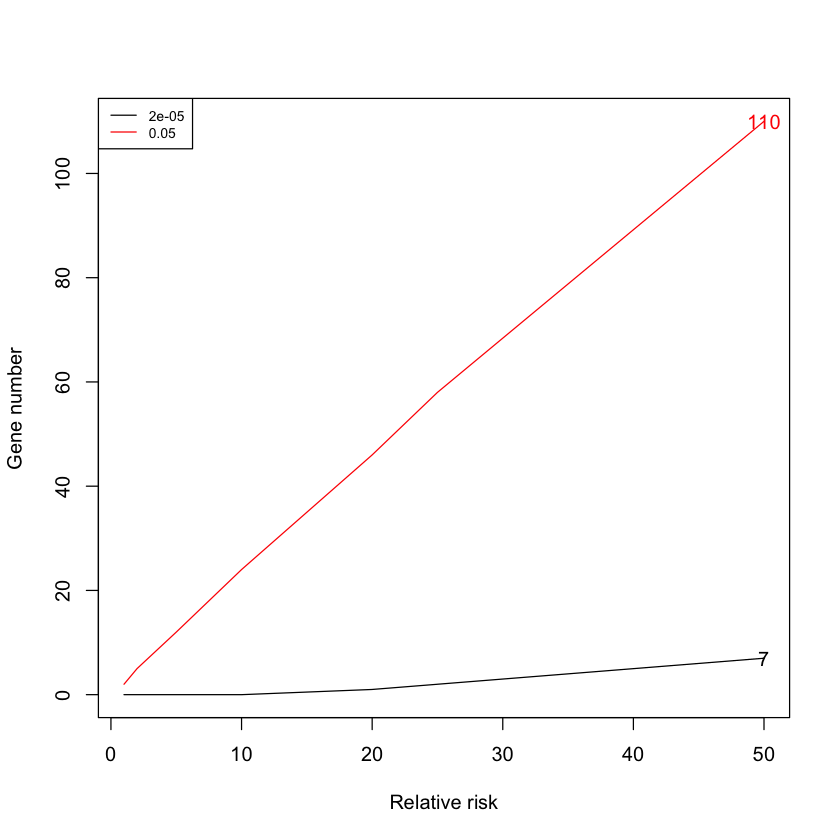

In [134]:
plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


gCount,0,0,0,0,0,0,2
gCount,0,0,0,0,1,2,7
gCount,0,0,0,0,2,3,10
gCount,0,0,1,2,5,7,18
gCount,0,1,3,7,14,19,41
gCount,2,5,12,24,46,58,110


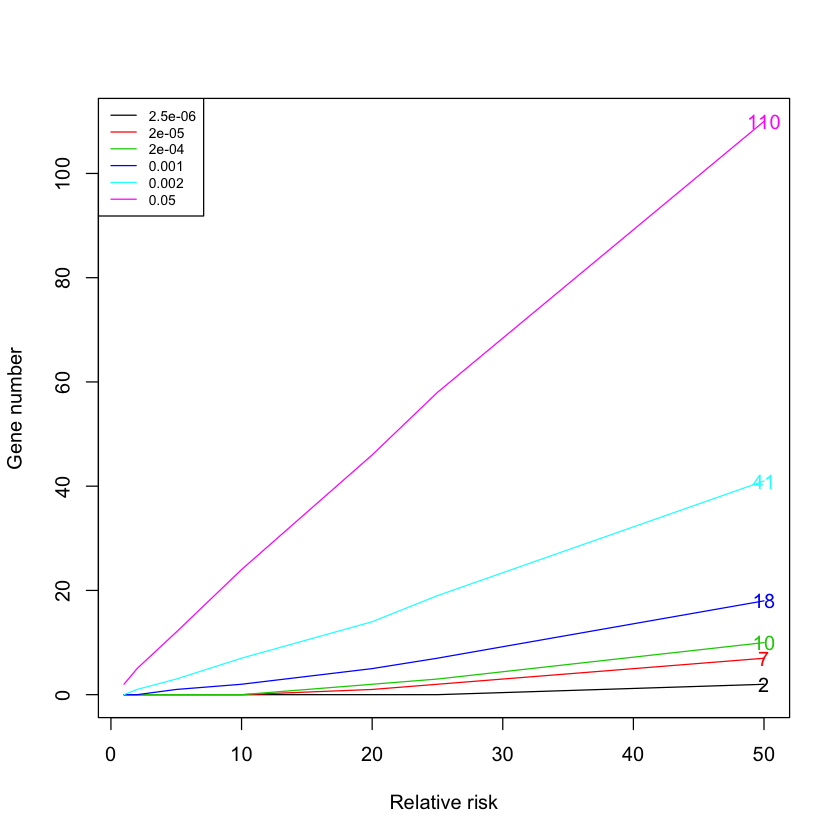

In [136]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y){
      y <- y[1:1000]
    length(y[y < alphaThreshold])
      }
      )))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


### We will summarize how many counts for each RR below.
 

In [14]:
countSum <- lapply(geneCountList, function(x) apply(x, 2, sum))
countSum[[1]]
rrList

[1]  39  44  59  50  88  87 135

[1]  1  2  5 10 20 25 50

23,19,28,34,57,70,124
58,59,68,80,120,124,190


39,44,59,50,88,87,135
42,35,60,63,78,109,190
46,39,37,63,77,87,162
41,45,45,76,75,80,157
41,39,49,57,82,106,156
44,49,40,54,80,97,162


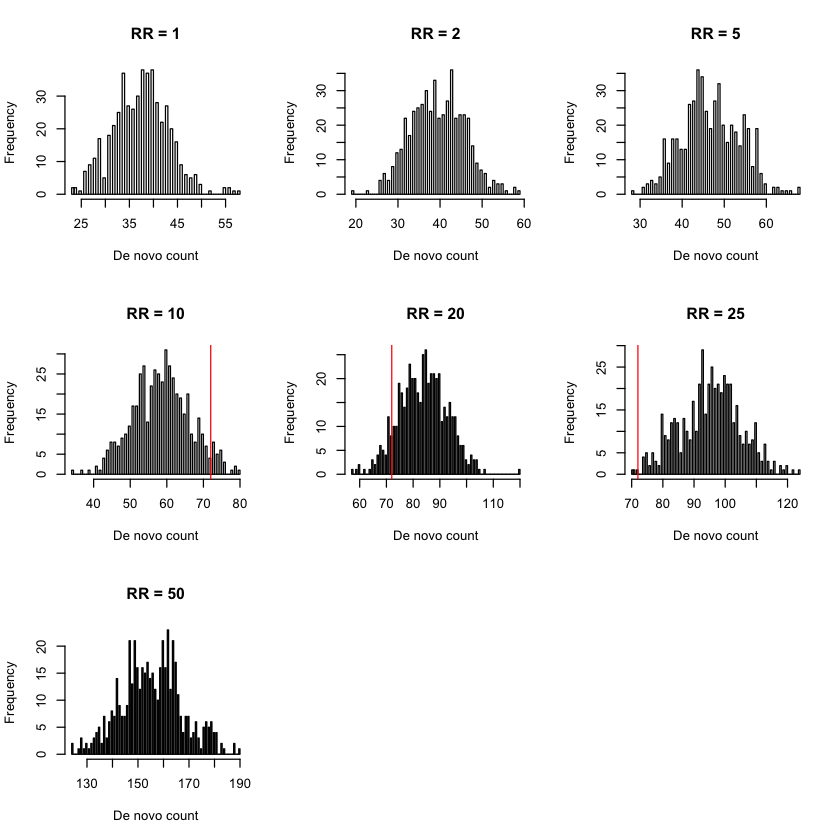

In [15]:
t.countSum <- do.call(rbind, countSum) ##See all simulated counts
apply(t.countSum, 2, range) ##See a range of all these values

head(t.countSum)

par(mfrow = c(3, 3))
for (ii in 1:length(rrList)){
    hist(t.countSum[, ii], 100, xlab = 'De novo count', main = paste("RR = ", rrList[ii], sep = ""))
    abline(v = floor(sum(data$dn.LoF)*550/2331), col = 'red' )
}

### Take a look at the predicted counts of de novos

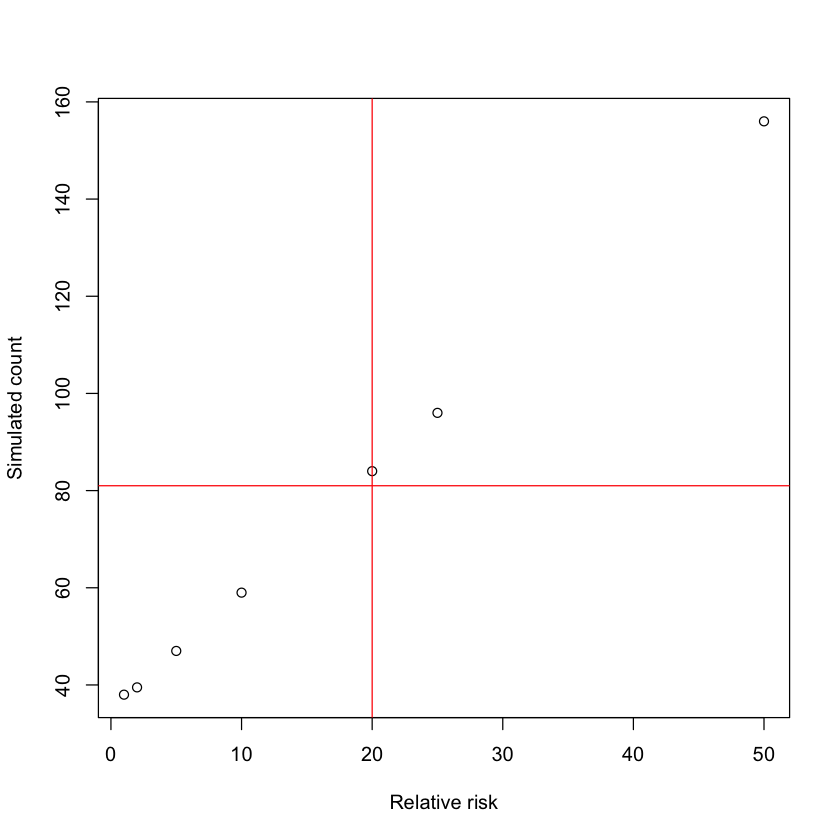

In [16]:
    Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nPredictedDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
    
countSumAverage <- apply(do.call(rbind, countSum), 2, median)

    
    
    plot(rrList, countSumAverage, xlab = 'Relative risk', ylab = 'Simulated count')
    
    abline(v = 20, col = 'red')
    abline(h = nPredictedDenovo, col = 'red') ## Draw a line for predicted counts



### Now, will check how many recurrent genes are from simulated data?

In [17]:
recurrentCount <- lapply(geneCountList, function(x) apply(x, 2, function(y) length(y[y>1])))
recurrentCount[[1]]

recurrentCountAll <- do.call(rbind, recurrentCount)

apply(recurrentCountAll, 2, median) ##Not strong, why is it? So, the way we let equal RRs for all risk genes is not suitable


[1] 0 1 0 0 5 2 8

[1]  0  0  0  0  2  3 10

### Take a look at the Poisson test result for all counts

In [18]:
poissonTestAll_data_allSimu[1:3, ]

apply(poissonTestAll_data_allSimu, 2, median)

poissonTestAll_data,4.068943e-01,1.518281e-01,5.949544e-04,2.614171e-02,1.070563e-12,2.551165e-12,3.992498e-35
poissonTestAll_data,2.372215e-01,6.642204e-01,3.606140e-04,7.327208e-05,3.764321e-09,1.176840e-21,2.481609e-70
poissonTestAll_data,9.058557e-02,4.068943e-01,5.363450e-01,7.327208e-05,7.974952e-09,2.551165e-12,2.122186e-51


[1] 4.709502e-01 3.763265e-01 6.815158e-02 5.949544e-04 3.226649e-11
[6] 6.976752e-16 1.328334e-47

# Use real counts from published data


## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations

#### Here, I randomly allocate counts to nGene, but counts should be allocated to the top 1000 genes


In [19]:
sum(data$dn.LoF)

[1] 308

# Mis3

In [20]:
message("Expected mis3 count: ", floor(sum(data$dn.mis3)*550/2331))

Expected mis3 count: 195


In [21]:
mutLoF0 <- data$mut.rate*mu.frac[2] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

##Choose nRiskGene = 1000 genes, using index
indexRiskGene <- sample(1:nGene, 1000)

Ntimes <- 500 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list()

poissonTestAll_data_allSimu <- NULL
poissonTestAll_data <- NULL

for (kk in 1:Ntimes) {

#rrList <- seq(1, 30, by = 1)
rrList <- c(1, 2, 5, 10, 20, 25, 50)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)

##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR #rgamma(1000, RR, rate = 1)
  
  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

    
    
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
    mutLoFallDenovo <- mutLoF0[geneCount > 0]
    poissonTestAll <- ppois(sum(geneCount) - 1, sum(mutLoF0)*2*Nsample, lower.tail = FALSE)
    
    poissonTestAll_data[ii] <- poissonTestAll
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
}


In [22]:
countSum <- lapply(geneCountList, function(x) apply(x, 2, sum))
countSum[[1]]
rrList

[1] 147 146 183 264 411 443 666

[1]  1  2  5 10 20 25 50

114,139,159,205,297,360,590
199,214,247,311,429,476,766


147,146,183,264,411,443,666
142,184,216,263,334,407,660
165,214,210,311,339,413,666
147,163,194,263,359,377,647
157,143,201,256,387,438,681
179,166,209,290,399,413,652


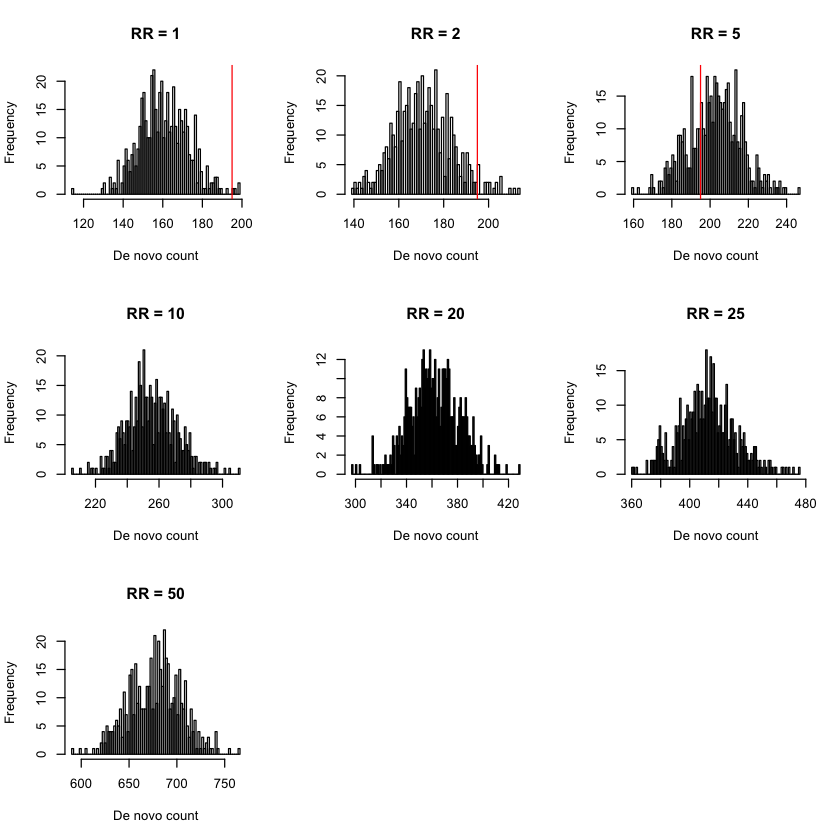

In [23]:
t.countSum <- do.call(rbind, countSum) ##See all simulated counts
apply(t.countSum, 2, range) ##See a range of all these values

head(t.countSum)

par(mfrow = c(3, 3))
for (ii in 1:length(rrList)){
    hist(t.countSum[, ii], 100, xlab = 'De novo count', main = paste("RR = ", rrList[ii], sep = ""))
    abline(v = floor(sum(data$dn.mis3)*550/2331), col = 'red' )
}

gCount,0,0,0,1,5,8,40
gCount,152,163,191,236,319,354,506


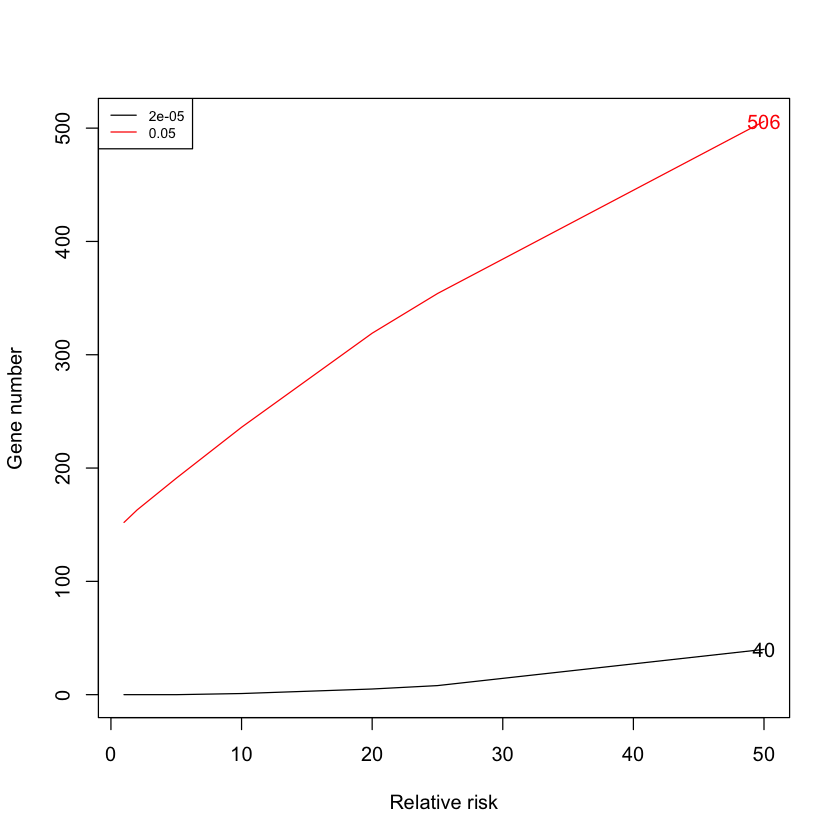

In [24]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


gCount,0,0,0,0,2,4,25
gCount,0,0,0,1,5,8,40
gCount,0,0,1,4,17,25,87
gCount,1,1,3,8,26,37,111
gCount,3,3,5,11,30,42,117
gCount,152,163,191,236,319,354,506


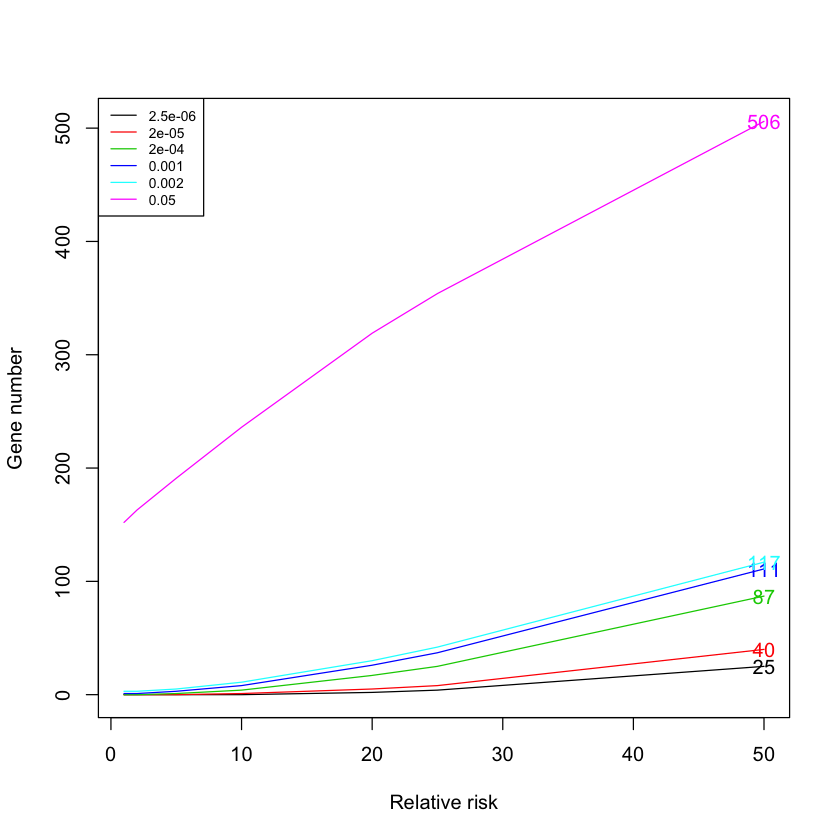

In [25]:
gCountAll <- NULL
alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){
  
outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y){
      y <- y[1:1000]
    length(y[y < alphaThreshold])
      }
      
      )))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]], 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)


In [26]:
recurrentCount <- lapply(geneCountList, function(x) apply(x, 2, function(y) length(y[y>1])))
recurrentCount[[1]]

recurrentCountAll <- do.call(rbind, recurrentCount)

apply(recurrentCountAll, 2, median) ##Not strong, why is it? So, the way we let equal RRs for all risk genes is not suitable


[1]   0   1   3  14  36  46 107

[1]   1   1   3   9  28  40 113

In [27]:
poissonTestAll_data_allSimu[1:3, ]

apply(poissonTestAll_data_allSimu, 2, median)

poissonTestAll_data,8.737153e-01,8.898124e-01,4.698943e-02,6.487387e-14,5.911290e-61,1.515082e-74,7.679692e-194
poissonTestAll_data,9.397883e-01,4.003643e-02,2.087383e-05,1.070099e-13,7.673841e-33,2.491957e-59,3.778568e-190
poissonTestAll_data,3.854819e-01,3.834438e-05,1.227056e-04,7.417639e-26,1.882256e-34,8.972972e-62,7.679692e-194


[1]  5.406546e-01  2.243083e-01  7.907252e-04  5.123890e-12  2.918203e-42
[6]  8.972972e-62 6.396445e-202

# Scale mutation rate

In [79]:
data <- read.csv("TADA/data/TADA_results.csv", header = TRUE, as.is = TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)

#Nsample_old <- 2231 ##There are 308 de novo mutations in this sample set
Nsample_old <- 3985+356 ## AUT+EPI LoF plus Mis3
Nsample <- 550
#Ncount_old <- sum(data$dn.LoF)
Ncount_old <- 2252  ## AUT+EPI LoF plus Mis3
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
nDenovo
nDenovo_NCR <- 60

mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

##Choose nRiskGene = 1000 genes, using index
indexRiskGene <- sample(1:nGene, 1000)

Ntimes <- 200 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list()

poissonTestAll_data_allSimu <- NULL
poissonTestAll_data <- NULL

poissonTestNCR_data_allSimu <- NULL
poissonTestNCR_data <- NULL

expected.null.ratio <- nDenovo / (2* sum(mutLoF0) *Nsample)
expected.null.ratio.ncr <- nDenovo_NCR / (2* sum(mutLoF0) *Nsample)

expected.null.ratio
expected.null.ratio.ncr


[1] 286

[1] 7.68363

[1] 1.61195

In [127]:
expected.null.ratio <- nDenovo / (2* sum(mutLoF0) *Nsample)
expected.null.ratio.ncr <- nDenovo_NCR / (2* sum(mutLoF0) *Nsample)


rrList <- c(1,seq(2, 50, by = 2))
#rrList <- c(1, 2, 5, 10, 20, 25, 50)

for (kk in 1:Ntimes) {


finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)


for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR #rgamma(1000, RR, rate = 1)

  expected.ratio <- nDenovo / (2*sum(mutLoF) *Nsample)
  
  geneCount <- rpois(nGene, mutLoF* (2*Nsample * expected.ratio))

    
    
  poissonTest <- ppois(geneCount - 1, lambda = mutLoF0 *(2*Nsample*expected.null.ratio), lower.tail = FALSE)
  
    mutLoFallDenovo <- mutLoF0[geneCount > 0]
    
 poissonTestAll <- ppois(sum(rpois(nGene, mutLoF *2*Nsample*expected.null.ratio)) - 1, 
                         sum(mutLoF0)*2*Nsample*expected.null.ratio, lower.tail = FALSE)
    
    poissonTestAll_data[ii] <- poissonTestAll

#    poissonTestNCR <- ppois(sum(rpois(1, sum(mutLoF0)*RR *2*Nsample*expected.null.ratio.ncr)) - 1, 
 #                           sum(mutLoF0)*2*Nsample*expected.null.ratio.ncr, lower.tail = FALSE)
    mutLoFncr <- mutLoF0*RR
    expected.ratio.ncr <- nDenovo_NCR / (2*sum(mutLoFncr) *Nsample)
    geneCountNCR <- rpois(nGene, mutLoFncr*2*Nsample*expected.ratio.ncr )
        poissonTestNCR <- ppois(sum(geneCountNCR) - 1, 
                            sum(mutLoF0)*2*Nsample*expected.null.ratio.ncr, lower.tail = FALSE)

    message("expected.ratio.ncr/expected.null.ratio.ncr: ", 
            expected.ratio.ncr/expected.null.ratio.ncr, 
           " geneCount: ", sum(geneCountNCR), " - ", nDenovo_NCR)


    poissonTestNCR_data[ii] <- poissonTestNCR
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
    poissonTestNCR_data_allSimu <- rbind(poissonTestNCR_data_allSimu, poissonTestNCR_data)
}




expected.ratio.ncr/expected.null.ratio.ncr: 1 geneCount: 770 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.5 geneCount: 739 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.25 geneCount: 733 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.166666666666667 geneCount: 732 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.125 geneCount: 692 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.1 geneCount: 759 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0833333333333333 geneCount: 712 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0714285714285714 geneCount: 768 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0625 geneCount: 737 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0555555555555556 geneCount: 716 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.05 geneCount: 754 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0454545454545455 geneCount: 738 - 60
expected.ratio.ncr/expected.null.ratio.ncr: 0.0416666666666667 geneCount: 771 - 60
expected.ratio.ncr/exp

In [120]:
b11 <- (cbind(mutLoFncr*2*Nsample*expected.ratio.ncr, 
           (mutLoF0)*2*Nsample*expected.null.ratio.ncr))
ppois(sum(geneCountNCR) - 1, 
                            sum(mutLoF0)*2*Nsample*expected.null.ratio.ncr, lower.tail = FALSE)
head(b11)
head(b11[, 1]/b11[, 2])

[1] 0

0.05325444,0.05325444
5.190491e-05,5.190491e-05
0.05330634,0.05330634
0.05880826,0.05880826
0.06405066,0.06405066
0.0001038098,0.0001038098


[1] 1 1 1 1 1 1

2.417568e-11,1.000000e+00
2.113659e-12,1.000000e+00
2.13448e-10,1.00000e+00
3.034136e-10,1.000000e+00
2.281775e-10,1.000000e+00
2.044311e-10,1.000000e+00
2.6778e-12,1.0000e+00
7.753461e-10,1.000000e+00
1.391793e-10,1.000000e+00
1.056996e-10,1.000000e+00
1.924085e-12,1.000000e+00


gCount,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gCount,2,2,2,2,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,2
gCount,5,5,5,5,5,5,4,5,5,5,⋯,5,5,5,5,5,5,5,5,5,5
gCount,20,21,21,20,20,20,20,20,20,20,⋯,20,20,21,21,20,20,21,21,21,20


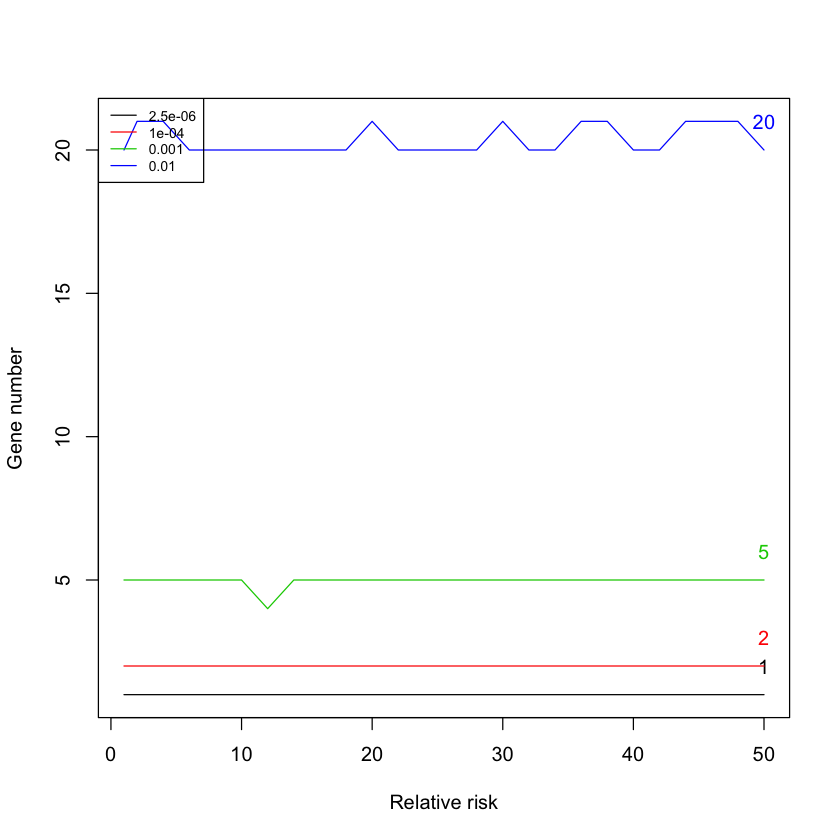

In [121]:
allOut2 <- do.call(rbind, geneCountforPowerList2)
t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1


gCountAll <- NULL
alpha0 <- c(2.5e-6, 1e-4, 1e-3, 0.01)
#alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){

outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y) {
   y1000 <- y[1:1000]
    length(y1000[y1000 < alphaThreshold]) })  )

)
gCount <- apply(outData, 2, function(x) ceiling(mean(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


#pdf("Eli.pdf")

plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]]+1, 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)

#dev.off()


In [122]:
dim(poissonTestAll_data_allSimu)

poissonTestAll_data_allSimu[1:3, 1:3]

poissonTestNCR_data_allSimu[1:3, 1:3]

[1] 605  26

poissonTestAll_data,0.1505061,0.4143463,0.0836539
poissonTestAll_data,0.284853019,0.391569438,0.001490486
poissonTestAll_data,9.498341e-01,9.191380e-01,1.112292e-06


poissonTestNCR_data,1.100508e-92,1.966589e-99,1.737060e-101
poissonTestNCR_data,4.982904e-90,4.523522e-98,4.523522e-98
poissonTestNCR_data,1.026098e-96,2.158200e-97,4.982904e-90


In [123]:
gCountLoF <- NULL
gCountNCR <- NULL
alpha0 <- c(2.5e-6, 1e-4, 1e-3, 0.01)

for (ii in 1:length(alpha0)){
    gLoF <- apply(poissonTestAll_data_allSimu, 2, function(yy)
        length(yy[yy <= alpha0[ii]])/length(yy))
        
        gCountLoF <- rbind(gCountLoF, gLoF)
        
        gNCR <- apply(poissonTestNCR_data_allSimu, 2, function(yy)
        length(yy[yy <= alpha0[ii]])/length(yy))
            
            gCountNCR <- rbind(gCountNCR, gNCR)

        
}


In [124]:
gCountLoF
gCountNCR

gLoF,0.338842975206612,0.338842975206612,0.393388429752066,0.83801652892562,0.991735537190083,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gLoF,0.338842975206612,0.342148760330579,0.543801652892562,0.945454545454545,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gLoF,0.338842975206612,0.360330578512397,0.67603305785124,0.985123966942149,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gLoF,0.342148760330579,0.419834710743802,0.874380165289256,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


gNCR,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gNCR,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gNCR,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
gNCR,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


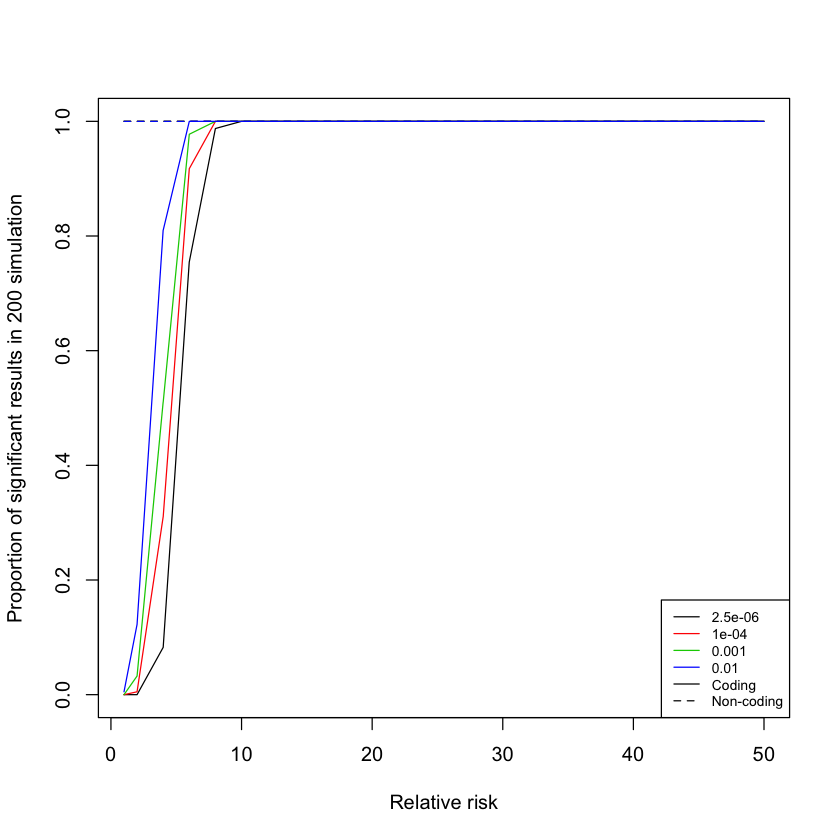

In [97]:
plot(range(rrList), c(0, 1), col = 'white', xlab = 'Relative risk', 
     ylab = paste('Proportion of significant results in ', Ntimes, ' simulation', sep = '') )

for (jj in 1:dim(gCountLoF)[1]){
    lines(rrList, gCountLoF[jj, ], col = jj, lty = 1)
        lines(rrList, gCountNCR[jj, ], col = jj, lty = 2)
}
legend("bottomright", legend = c(alpha0, "Coding", "Non-coding"), 
       col = c(1:length(alpha0), 1, 1), cex = 0.7, lty = c(rep(1, length(alpha0)), 1, 2))
       
#legend("topright", legend = c("Coding", "Non-coding"), cex = 0.7, lty = 1:2)

In [98]:
c(rep(1, length(alpha0), 1, 2))

[1] 1

In [99]:
length(alpha0)

[1] 4

In [104]:
ncrData <- read.table("asd-enhancers_filt.BED_usingbasemutation", header = FALSE, sep = "\t")
head(ncrData)

,V1,V2,V3,V4
1,chr1,1874850,1876050,Repressed_Enhancer_0 1201 1.4412e-05
2,chr1,1875000,1876400,Active_Enhancer_0 1401 1.6812e-05
3,chr1,1878800,1879050,Repressed_Enhancer_1 251 3.012e-06
4,chr1,1890950,1892450,Repressed_Enhancer_2 1501 1.8012e-05
5,chr1,1934400,1936100,Repressed_Enhancer_3 1701 2.0412e-05
6,chr1,1934900,1935900,Active_Enhancer_1 1001 1.2012e-05


In [108]:
mutNCR <- ncrData[, dim(ncrData)[2]]
mutLoF0 <- as.numeric(mutNCR)

In [112]:
expected.null.ratio <- nDenovo_NCR / (2* sum(mutLoF0) *Nsample)


Ntimes <- 1

rrList <- c(1,seq(2, 50, by = 2))
#rrList <- c(1, 2, 5, 10, 20, 25, 50)

for (kk in 1:Ntimes) {


finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)


for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
#  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF <- mutLoF*RR #rgamma(1000, RR, rate = 1)

  expected.ratio <- nDenovo_NCR/ (2*sum(mutLoF) *Nsample)
  
  geneCount <- rpois(nGene, mutLoF* (2*Nsample * expected.ratio)) ##It's wrong because they are cancelled out
        
  poissonTest <- ppois(geneCount - 1, lambda = mutLoF0 *(2*Nsample*expected.null.ratio), lower.tail = FALSE)
  
    
  finalResult[, ii] <- poissonTest
  geneCountTable[, ii] <- geneCount
}

geneCountList[[kk]] <- geneCountTable

geneCountforPower2 <- rbind(geneCountforPower2, t1)
geneCountforPowerList2[[kk]] <- finalResult

    poissonTestAll_data_allSimu <- rbind(poissonTestAll_data_allSimu, poissonTestAll_data)
    poissonTestNCR_data_allSimu <- rbind(poissonTestNCR_data_allSimu, poissonTestNCR_data)
}




[1] 2.249213e-07

2.417568e-11,1.000000e+00
2.113659e-12,1.000000e+00
2.13448e-10,1.00000e+00
3.034136e-10,1.000000e+00
2.281775e-10,1.000000e+00
2.044311e-10,1.000000e+00
2.6778e-12,1.0000e+00
7.753461e-10,1.000000e+00
1.391793e-10,1.000000e+00
1.056996e-10,1.000000e+00
1.924085e-12,1.000000e+00


gCount,3,3,3,3,4,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,4
gCount,36,35,36,36,37,37,35,37,37,36,⋯,36,37,37,36,36,36,36,36,36,36
gCount,106,104,105,105,103,106,103,105,104,104,⋯,104,106,105,104,105,104,106,104,105,105
gCount,424,423,426,424,423,426,423,423,425,423,⋯,422,423,424,422,423,424,427,422,424,422


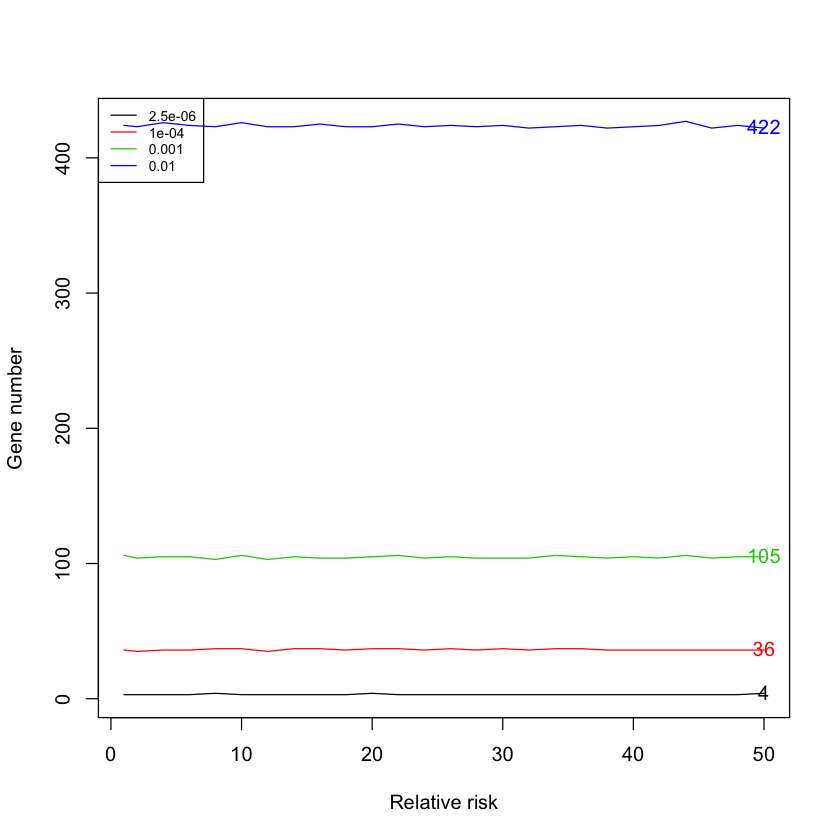

In [113]:
allOut2 <- do.call(rbind, geneCountforPowerList2)
t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1


gCountAll <- NULL
alpha0 <- c(2.5e-6, 1e-4, 1e-3, 0.01)
#alpha0 <- c(2.5e-6, 2e-5, 2e-4, 1e-3, 2e-3, 0.05)
#alpha0 <- c(2e-5, 0.05)
#alpha0 <- c(2e-5, 0.05)
for (alphaThreshold in alpha0){

outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y) {
   y1000 <- y
    length(y1000[y1000 < alphaThreshold]) })  )

)
gCount <- apply(outData, 2, function(x) ceiling(mean(x))) ###How many genes with this threshold?
gCount
gCountAll <- rbind(gCountAll, gCount)
}
gCountAll


#pdf("Eli.pdf")

plot(rrList, gCountAll[dim(gCountAll)[1], ], col = 'white', xlab = 'Relative risk', ylab = 'Gene number',
     ylim = range(as.numeric(gCountAll)))
for (ii in 1:dim(gCountAll)[1]){
  lines(rrList, gCountAll[ii, ], col = ii)
    text(rrList[length(rrList)], gCountAll[ii, dim(gCountAll)[2]]+1, 
        gCountAll[ii, dim(gCountAll)[2]], col  = ii)
}

legend("topleft", legend = alpha0, col = 1:length(alpha0), cex = 0.7, lty = 1)

#dev.off()
